In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
from EvaluationLog import AttentionScoresLog
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/home/wdwatson2/projects/CAT-Transformer/model')
from testingModel import CATTransformer, MyFTTransformer, Combined_Dataset, train, test

device_in_use = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device_in_use)

cuda


In [2]:
df_train = pd.read_csv('/home/wdwatson2/projects/CAT-Transformer/datasets/helena/train.csv')
df_test = pd.read_csv('/home/wdwatson2/projects/CAT-Transformer/datasets/helena/test.csv')
df_val = pd.read_csv('/home/wdwatson2/projects/CAT-Transformer/datasets/helena/validation.csv')

cont_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27']
target = ['class']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put one of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print("target classes",target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

#Wrapping in Dataset
train_dataset = Combined_Dataset(df_train, cat_columns=[], num_columns=cont_columns, task1_column='class')
val_dataset = Combined_Dataset(df_val, cat_columns=[], num_columns=cont_columns, task1_column='class')
test_dataset = Combined_Dataset(df_test, cat_columns=[], num_columns=cont_columns, task1_column='class')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


target classes [100]


In [3]:
attention_log = AttentionScoresLog()

models = ["CAT", "FT"]
num_layers = [1,2,5]
datasets = ["Helena"]

for model in models:
    for layer in num_layers:
        attention_log.add_model_layers(model, layer)

attention_log.add_new_dataset('Helena')

In [4]:
model = CATTransformer(n_cont=len(cont_columns),
                       cat_feat=[],
                       targets_classes=target_classes,
                       get_attn=True,
                       num_layers=2).to(device_in_use)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001)

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 

train_attns = []
test_attns = []

epochs = 40

for t in range(epochs):
    train_loss, train_acc, train_attn = train(regression_on=False, 
                                  get_attn=True,
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc, test_attn = test(regression_on=False,
                               get_attn=True,
                               dataloader=test_dataloader,
                               model=model,
                               loss_function=loss_function,
                               device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)
    train_attns.append(train_attn)
    test_attns.append(test_attn)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    test_metrics = f"Test: Loss {(test_loss)}, Accuracy {(test_acc)}"
    print(f"{epoch_str:15} | {train_metrics:65} | {test_metrics:65}")

attention_log.add_attention_scores('CAT', 2, 'Helena', train_attns, test_attns)


Epoch [ 1/40]   | Train: Loss 4.2137451424945, Accuracy 0.07965028376098342         | Test: Loss 3.821340114642412, Accuracy 0.12535787321063394       
Epoch [ 2/40]   | Train: Loss 3.6508810080629486, Accuracy 0.1797664175997546       | Test: Loss 3.3495854903490114, Accuracy 0.23977505112474437      
Epoch [ 3/40]   | Train: Loss 3.3095533514821995, Accuracy 0.2458531454740671       | Test: Loss 3.142861158419878, Accuracy 0.28282208588957053       
Epoch [ 4/40]   | Train: Loss 3.15039156668679, Accuracy 0.2729802572474089         | Test: Loss 3.034419897275093, Accuracy 0.2987730061349693        
Epoch [ 5/40]   | Train: Loss 3.052946988430769, Accuracy 0.2872888226658194        | Test: Loss 2.950749623469817, Accuracy 0.31206543967280165       
Epoch [ 6/40]   | Train: Loss 2.9741371996575894, Accuracy 0.29920897517365297      | Test: Loss 2.9092582983848376, Accuracy 0.3114519427402863       
Epoch [ 7/40]   | Train: Loss 2.917948954598198, Accuracy 0.31075662291561673       | Te

In [ ]:
train_scores, test_scores = attention_log.get_attention_scores('CAT', 2, 'Helena')

#SHAPES and Meaning:
#epochs:batch:layer:avg_attn_for_keys over an entire batch

#Not super meaningful, but will give us a visual of attention scores for each feature, for each epoch
# len(train_scores)
test = np.array(train_scores).squeeze(0)
test.shape
avg_test = test.mean(1)
avg_test.shape

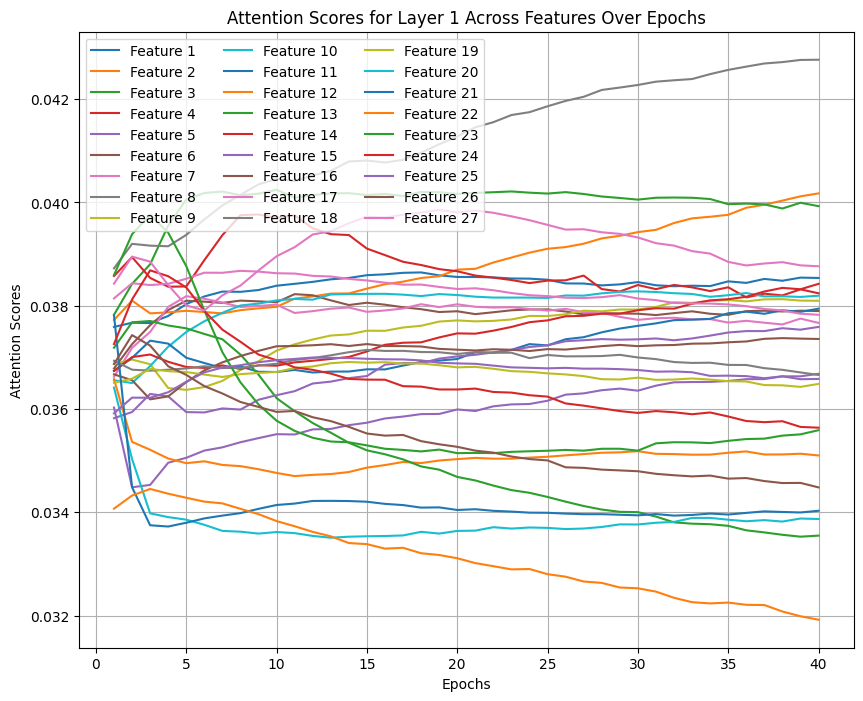

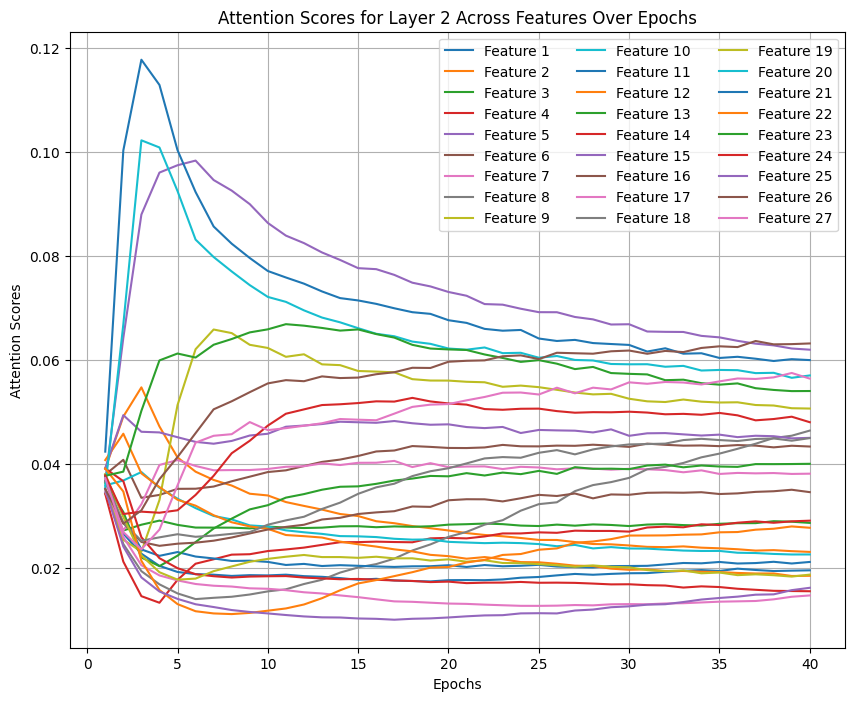

In [12]:
#Visuallizing over layers 

epochs = range(1, avg_test.shape[0]+1)  
num_features = avg_test.shape[2]

for layer_idx in range(2):  
    plt.figure(figsize=(10, 8))

    # Plotting all features for the current layer
    for feature_idx in range(num_features):
        plt.plot(epochs, avg_test[:, layer_idx, feature_idx], label=f'Feature {feature_idx + 1}')

    plt.title(f'Attention Scores for Layer {layer_idx + 1} Across Features Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Attention Scores')
    plt.legend(ncol=3) 
    plt.grid(True)
    plt.show()


In [13]:
avg_test = avg_test.mean(1)
avg_test.shape

(40, 27)

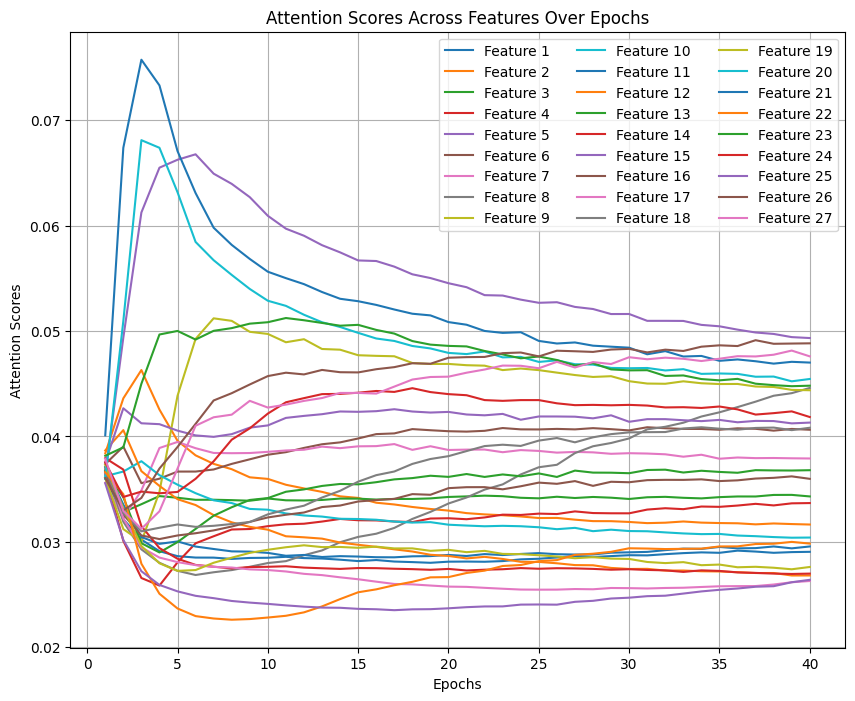

In [14]:
epochs = range(1, avg_test.shape[0]+1)  
num_features = avg_test.shape[1]

plt.figure(figsize=(10, 8))

# Plotting all features for the current layer
for feature_idx in range(num_features):
    plt.plot(epochs, avg_test[:, feature_idx], label=f'Feature {feature_idx + 1}')

plt.title(f'Attention Scores Across Features Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Attention Scores')
plt.legend(ncol=3) 
plt.grid(True)
plt.show()